In [1]:
#1. More algorithm benchmarks
# BV, Hidden shift, Add, SquareRoot, Supremacy
#2. Large topologies and hypercube
#3. IBM vs Surface

#TODO: collect list of functions to test
#TODO: data that collects number of swap gates added during movement, (gate counts before and after swap decomp)

In [2]:
import sys
sys.path.append("..")
import logging
#logging.basicConfig(level=0)

In [11]:
"""Define circuits to test"""
from supermarq.benchmarks import *
from supermarq.features import cirq_to_qiskit

class CircuitTranspilerBenchmark():
    #TODO: circuit_lambda could take multiple params if desired
    def __init__(self, circuit_lambda, q_range, label):
        self.circuit_lambda = circuit_lambda
        self.q_range = q_range
        self.label = label

circuits = {}
q_range = [8, 16, 24, 32, 48, 64, 80]
depth = 10

#Random
from qiskit.circuit.random import random_circuit
random_lambda = lambda q: random_circuit(q, depth, measure=False, max_operands=2)
label = "Randomized_QC"
circuits[label] = (CircuitTranspilerBenchmark(random_lambda, q_range, label=label))

#Quantum Volume
from qiskit.circuit.library import QuantumVolume
qv_lambda = lambda q: QuantumVolume(q, depth)
label = "Quantum_Volume"
circuits[label] = (CircuitTranspilerBenchmark(qv_lambda, q_range, label=label))

#QFT
from qiskit.circuit.library.basis_change import QFT
qft_lambda = lambda q: QFT(q)
label = "QFT"
circuits[label] = (CircuitTranspilerBenchmark(qft_lambda, q_range, label=label))

#Inverse QFT
inverse_qft_lambda = lambda q: QFT(q, inverse=True)
label = "IQFT"
circuits[label] = (CircuitTranspilerBenchmark(inverse_qft_lambda, q_range, label=label))

#QAOA, takes a long time to generate - consider capping max size before 20
qaoa_lambda = lambda q: cirq_to_qiskit(QAOAFermionicSwapProxy(q).circuit())
label = "QAOA_Fermionic_Swap"
circuits[label] = (CircuitTranspilerBenchmark(qaoa_lambda, q_range, label=label))

#QAOA vanilla
qaoa_vanilla_lambda = lambda q: cirq_to_qiskit(QAOAVanillaProxy(q).circuit())
label = "QAOA_Vanilla"
circuits[label] = (CircuitTranspilerBenchmark(qaoa_vanilla_lambda, q_range, label=label))

#VQE - very slow to generate
vqe_lambda = lambda q: cirq_to_qiskit(VQEProxy(q, 4).circuit()[0])
label = "VQE"
circuits[label] = (CircuitTranspilerBenchmark(vqe_lambda, q_range, label=label))

#Simulation 
hamiltonian_lambda = lambda q: cirq_to_qiskit(HamiltonianSimulation(q, 1/depth, 1).circuit())
label = "TIM_Hamiltonian"
circuits[label] = (CircuitTranspilerBenchmark(hamiltonian_lambda, q_range, label=label))

#GHZ
ghz_lambda = lambda q: cirq_to_qiskit(GHZ(q).circuit())
label = "GHZ"
circuits[label] = (CircuitTranspilerBenchmark(ghz_lambda, q_range, label=label))

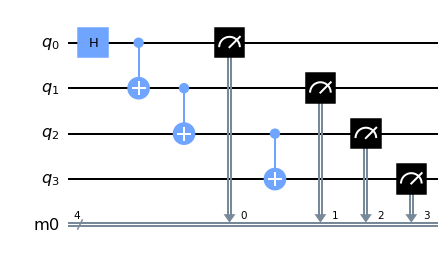

In [4]:
qc = circuits["GHZ"].circuit_lambda(4)
qc.draw(output='mpl')

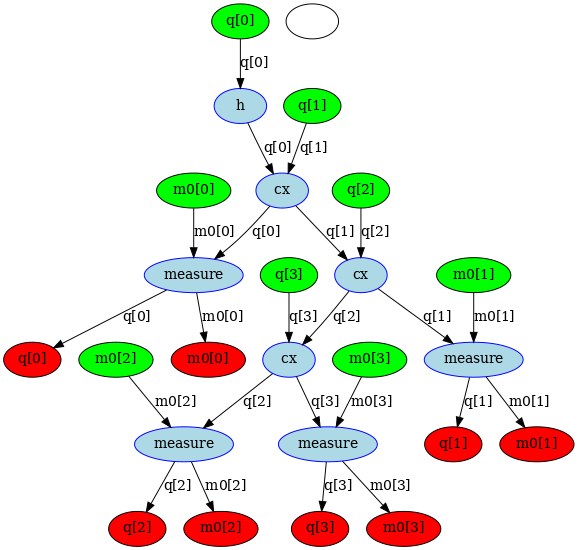

In [5]:
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer
dag = circuit_to_dag(qc)
dag_drawer(dag)

In [7]:
"""Define backends to test"""
from backend_utils import *
from utils.transpiler_passes import level_0_pass_manager

class BackendTranspilerBenchmark():
    def __init__(self, backend, pm, label):
        self.backend = backend
        self.pass_manager = pm
        self.label = label
        self.times = []

backends = {}

backend_hatlab = FakeHatlab(router_as_qubits=True)
pm_hatlab = level_0_pass_manager(backend_hatlab, basis_gate="riswap")
label = "Hatlab-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_hatlab, pm_hatlab, label)

backend_lattice = FakeSurfaceCode(twoqubitgate="riswap")
pm_lattice = level_0_pass_manager(backend_lattice, basis_gate="riswap")
label = "Lattice-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_lattice, pm_lattice, label)

backend_lattice = FakeSurfaceCode(twoqubitgate="cx")
pm_lattice = level_0_pass_manager(backend_lattice, basis_gate="cx")
label = "Lattice-CX"
backends[label] = BackendTranspilerBenchmark(backend_lattice, pm_lattice, label)

"""Large Backends"""
#Large Lattice
backend_lattice = FakeSurfaceCode(twoqubitgate="cx", qubit_size=81, row_length=9)
pm_lattice = level_0_pass_manager(backend_lattice, basis_gate="cx")
label = "Lattice-Large-CX"
backends[label] = BackendTranspilerBenchmark(backend_lattice, pm_lattice, label)

backend_lattice = FakeSurfaceCode(twoqubitgate="riswap", qubit_size=81, row_length=9)
pm_lattice = level_0_pass_manager(backend_lattice, basis_gate="riswap")
label = "Lattice-Large-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_lattice, pm_lattice, label)

#Large Hypercubes
backend_hypercube = FakeHyperCubeV2(7, twoqubitgate="cx")
pm_hypercube = level_0_pass_manager(backend_hypercube, basis_gate="cx")
label = "Hypercube-Large-CX"
backends[label] = BackendTranspilerBenchmark(backend_hypercube, pm_hypercube, label)

backend_hypercube = FakeHyperCubeV2(7, twoqubitgate="riswap")
pm_hypercube = level_0_pass_manager(backend_hypercube, basis_gate="riswap", critical_path=True)
label = "Hypercube-Large-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_hypercube, pm_hypercube, label)

#Large Hatlab
backend_hatlab = FakeHatlab(dimension=2, router_as_qubits=True)
pm_hatlab = level_0_pass_manager(backend_hatlab, basis_gate="riswap", critical_path=True)
label = "Hatlab-Large-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_hatlab, pm_hatlab, label)

large_backends = [backend[1] for backend in backends.items() if "Large" in backend[0]]

This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially cr

In [8]:
from backend_utils.backend_analysis_pass import TopologyAnalysis
from qiskit.transpiler.passmanager import PassManager
from qiskit import QuantumCircuit
qc = QuantumCircuit(1)
for backend_label, backend_obj in backends.items():
    print(backend_label)
    pm1 = PassManager(TopologyAnalysis(backend_obj.backend))
    pm1.run(qc)
    for key, value in pm1.property_set.items():
        print(key,value)
    print()

Hatlab-Riswap
Diameter 3.0
Avg_Distance 2.15
Degree 7
Bisection Width NotImplementedError

Lattice-Riswap
Diameter 7.0
Avg_Distance 2.85
Degree 4
Bisection Width NotImplementedError

Lattice-CX
Diameter 7.0
Avg_Distance 2.85
Degree 4
Bisection Width NotImplementedError

Lattice-Large-CX
Diameter 16.0
Avg_Distance 5.925925925925926
Degree 4
Bisection Width NotImplementedError

Lattice-Large-Riswap
Diameter 16.0
Avg_Distance 5.925925925925926
Degree 4
Bisection Width NotImplementedError

Hypercube-Large-CX
Diameter 7.0
Avg_Distance 3.5
Degree 7
Bisection Width NotImplementedError

Hypercube-Large-Riswap
Diameter 7.0
Avg_Distance 3.5
Degree 7
Bisection Width NotImplementedError

Hatlab-Large-Riswap
Diameter 9.0
Avg_Distance 5.808956916099773
Degree 7
Bisection Width NotImplementedError



In [13]:
#make a plot :)
import matplotlib.pyplot as plt

def benchmark(backends, circuit_generator, q_range=None):
    #override qrange if provided
    if q_range is None:
        q_range = circuit_generator.q_range
        
    #reset time arrays
    for backend in backends:
        backend.times = []
        
    for q in q_range:
        #create new variable sized lambda circuit
        qc = circuit_generator.circuit_lambda(q)

        for backend in backends:
            #logging.info(f"Transpiler qc{q} for {backend.label}")
            print(f"Transpiler qc{q} for {backend.label}")
            backend.pass_manager.run(qc)
            backend.times.append(backend.pass_manager.property_set["duration_longest_path_length"])

    for backend in backends:
        plt.plot(q_range, backend.times, '-o', label=backend.label)

    plt.xlabel(circuit_generator.label)
    plt.ylabel("circuit duration")
    plt.legend()

    #savefig
    filename = f"images/large_{circuit_generator.label}"
    import os
    i = 0
    while os.path.exists('{}{:d}.png'.format(filename, i)):
        i += 1
    plt.savefig('{}{:d}.png'.format(filename, i), facecolor='white')

Transpiler qc4 for Lattice-Large-CX
Layout score 0.0
{'rz': 292, 'sx': 182, 'cx': 60, 'x': 33, 'measure': 4}
{'measure': 4, 'cx': 60, 'rz': 277, 'sx': 182, 'x': 31}
{'measure': 4, 'cx': 60, 'rz': 277, 'sx': 182, 'x': 31}
Transpiler qc4 for Lattice-Large-Riswap
Layout score 0.0
{'rz': 284, 'sx': 163, 'riswap': 60, 'x': 1, 'measure': 4}
{'measure': 4, 'riswap': 60, 'sx': 185, 'rz': 306}
{'measure': 4, 'riswap': 60, 'sx': 185, 'rz': 306}
Transpiler qc4 for Hypercube-Large-CX
Layout score 20.0
{'rz': 292, 'sx': 182, 'cx': 60, 'x': 33, 'swap': 2, 'measure': 4}
{'measure': 4, 'cx': 66, 'rz': 293, 'sx': 190, 'x': 31}
{'measure': 4, 'cx': 66, 'rz': 293, 'sx': 190, 'x': 31}
Transpiler qc4 for Hypercube-Large-Riswap
Layout score 20.0
{'rz': 284, 'sx': 163, 'riswap': 60, 'swap': 2, 'x': 1, 'measure': 4}
{'measure': 4, 'riswap': 66, 'rz': 332, 'sx': 201, 'x': 1}
{'measure': 1, 'riswap': 46, 'rz': 137, 'sx': 93}
Transpiler qc4 for Hatlab-Large-Riswap
Layout score 0.0
{'rz': 284, 'sx': 163, 'riswap'

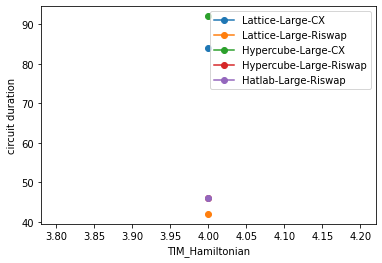

In [14]:
circuit_gen = circuits["TIM_Hamiltonian"]
#with critical path turned off
benchmark(backends=large_backends, circuit_generator=circuit_gen, q_range=[4])

Important data- note that the hypercube inserts more swaps than hatlab (172 vs 119), therefore decomposes to more riswaps (1094 vs 935); however, in the critical path hypercube now has less riswaps than hatlab (402 vs 435). This means that more of the swaps that are happening the in the hypercube are parallizable? Suggests better placement and routing algorithms are still needed - problem is that they become very slow. Except, Hatlab has a better layout score? That must mean that BasicSwapPass is just really bad?

Transpiler qc30 for Hypercube-Large-Riswap
Layout score 500.0
{'rz': 2650, 'sx': 1489, 'riswap': 580, 'swap': 172, 'x': 1, 'measure': 30}
{'measure': 30, 'riswap': 1094, 'sx': 3328, 'rz': 5477, 'x': 30}
{'measure': 1, 'riswap': 402, 'sx': 742, 'rz': 1133, 'x': 2}
Transpiler qc30 for Hatlab-Large-Riswap
Layout score 160.0
{'rz': 2650, 'sx': 1489, 'riswap': 580, 'swap': 119, 'x': 1, 'measure': 30}
{'measure': 30, 'riswap': 935, 'rz': 4682, 'sx': 2817, 'x': 33}
{'measure': 2, 'riswap': 435, 'rz': 1209, 'sx': 787, 'x': 10}


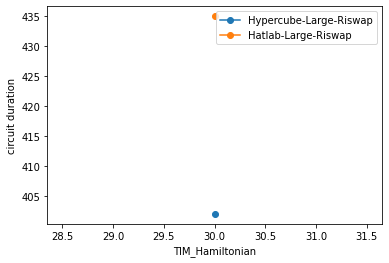

In [7]:
#with critical path turned on
circuit_gen = circuits["TIM_Hamiltonian"]
benchmark(backends=[backends["Hypercube-Large-Riswap"], backends["Hatlab-Large-Riswap"]], circuit_generator=circuit_gen, q_range=[30])

Transpiler qc8 for Lattice-Large-CX
Transpiler qc8 for Lattice-Large-Riswap
Transpiler qc8 for Hypercube-Large-CX
Transpiler qc8 for Hypercube-Large-Riswap
Transpiler qc8 for Hatlab-Large-Riswap
Transpiler qc16 for Lattice-Large-CX
Transpiler qc16 for Lattice-Large-Riswap
Transpiler qc16 for Hypercube-Large-CX
Transpiler qc16 for Hypercube-Large-Riswap
Transpiler qc16 for Hatlab-Large-Riswap
Transpiler qc24 for Lattice-Large-CX
Transpiler qc24 for Lattice-Large-Riswap
Transpiler qc24 for Hypercube-Large-CX
Transpiler qc24 for Hypercube-Large-Riswap
Transpiler qc24 for Hatlab-Large-Riswap
Transpiler qc32 for Lattice-Large-CX
Transpiler qc32 for Lattice-Large-Riswap
Transpiler qc32 for Hypercube-Large-CX
Transpiler qc32 for Hypercube-Large-Riswap
Transpiler qc32 for Hatlab-Large-Riswap
Transpiler qc48 for Lattice-Large-CX
Transpiler qc48 for Lattice-Large-Riswap
Transpiler qc48 for Hypercube-Large-CX
Transpiler qc48 for Hypercube-Large-Riswap
Transpiler qc48 for Hatlab-Large-Riswap
Trans

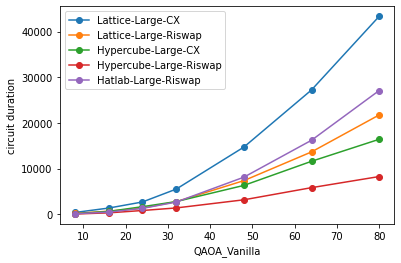

In [11]:
circuit_gen = circuits["QAOA_Vanilla"]
benchmark(backends=large_backends, circuit_generator=circuit_gen)

Transpiler qc8 for Lattice-Large-CX
Transpiler qc8 for Lattice-Large-Riswap
Transpiler qc8 for Hypercube-Large-CX
Transpiler qc8 for Hypercube-Large-Riswap
Transpiler qc8 for Hatlab-Large-Riswap
Transpiler qc16 for Lattice-Large-CX
Transpiler qc16 for Lattice-Large-Riswap
Transpiler qc16 for Hypercube-Large-CX
Transpiler qc16 for Hypercube-Large-Riswap
Transpiler qc16 for Hatlab-Large-Riswap
Transpiler qc24 for Lattice-Large-CX
Transpiler qc24 for Lattice-Large-Riswap
Transpiler qc24 for Hypercube-Large-CX
Transpiler qc24 for Hypercube-Large-Riswap
Transpiler qc24 for Hatlab-Large-Riswap
Transpiler qc32 for Lattice-Large-CX
Transpiler qc32 for Lattice-Large-Riswap
Transpiler qc32 for Hypercube-Large-CX
Transpiler qc32 for Hypercube-Large-Riswap
Transpiler qc32 for Hatlab-Large-Riswap
Transpiler qc48 for Lattice-Large-CX
Transpiler qc48 for Lattice-Large-Riswap
Transpiler qc48 for Hypercube-Large-CX
Transpiler qc48 for Hypercube-Large-Riswap
Transpiler qc48 for Hatlab-Large-Riswap
Trans

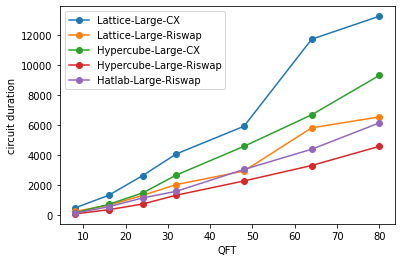

In [9]:
circuit_gen = circuits["QFT"]
benchmark(backends=large_backends, circuit_generator=circuit_gen)

Transpiler qc8 for Lattice-Large-CX
Transpiler qc8 for Lattice-Large-Riswap
Transpiler qc8 for Hypercube-Large-CX
Transpiler qc8 for Hypercube-Large-Riswap
Transpiler qc8 for Hatlab-Large-Riswap
Transpiler qc16 for Lattice-Large-CX
Transpiler qc16 for Lattice-Large-Riswap
Transpiler qc16 for Hypercube-Large-CX
Transpiler qc16 for Hypercube-Large-Riswap
Transpiler qc16 for Hatlab-Large-Riswap
Transpiler qc24 for Lattice-Large-CX
Transpiler qc24 for Lattice-Large-Riswap
Transpiler qc24 for Hypercube-Large-CX
Transpiler qc24 for Hypercube-Large-Riswap
Transpiler qc24 for Hatlab-Large-Riswap
Transpiler qc32 for Lattice-Large-CX
Transpiler qc32 for Lattice-Large-Riswap
Transpiler qc32 for Hypercube-Large-CX
Transpiler qc32 for Hypercube-Large-Riswap
Transpiler qc32 for Hatlab-Large-Riswap
Transpiler qc48 for Lattice-Large-CX
Transpiler qc48 for Lattice-Large-Riswap
Transpiler qc48 for Hypercube-Large-CX
Transpiler qc48 for Hypercube-Large-Riswap
Transpiler qc48 for Hatlab-Large-Riswap
Trans

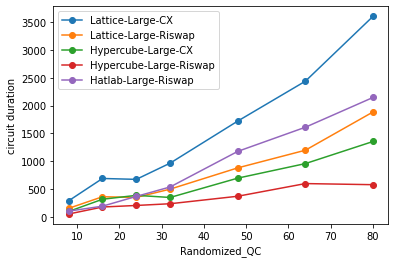

In [10]:
circuit_gen = circuits["Randomized_QC"]
benchmark(backends=large_backends, circuit_generator=circuit_gen)

Transpiler qc8 for Lattice-Large-CX
Layout score 0.0
{'rz': 3, 'sx': 1, 'cx': 7, 'measure': 8}
{'measure': 8, 'cx': 7, 'sx': 5, 'rz': 8}
{'measure': 1, 'cx': 7, 'sx': 4, 'rz': 6}
Transpiler qc8 for Lattice-Large-Riswap
Layout score 0.0
{'rz': 66, 'sx': 30, 'riswap': 14, 'measure': 8}
{'measure': 8, 'riswap': 14, 'rz': 87, 'sx': 51}
{'measure': 1, 'riswap': 14, 'rz': 45, 'sx': 30}
Transpiler qc8 for Hypercube-Large-CX
Layout score 4.0
{'rz': 3, 'sx': 1, 'cx': 7, 'swap': 5, 'measure': 8}
{'measure': 8, 'cx': 18, 'rz': 73, 'sx': 49}
{'measure': 1, 'cx': 18, 'rz': 45, 'sx': 30}
Transpiler qc8 for Hypercube-Large-Riswap
Layout score 8.0
{'rz': 66, 'sx': 30, 'riswap': 14, 'swap': 5, 'measure': 8}
{'measure': 8, 'riswap': 25, 'sx': 80, 'rz': 136, 'x': 4}
{'measure': 1, 'riswap': 25, 'sx': 48, 'rz': 72}
Transpiler qc8 for Hatlab-Large-Riswap
Layout score 2.0
{'rz': 66, 'sx': 30, 'riswap': 14, 'swap': 4, 'measure': 8}
{'measure': 8, 'riswap': 26, 'sx': 86, 'rz': 146, 'x': 3}
{'measure': 2, 'ris

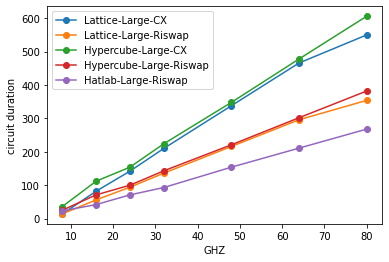

In [11]:
circuit_gen = circuits["GHZ"]
benchmark(backends=large_backends, circuit_generator=circuit_gen)

In [59]:
circuit_gen = circuits["VQE"]
benchmark(backends=large_backends, circuit_generator=circuit_gen, q_range=[8, 16, 32])

Transpiler qc8 for Lattice-Large-CX
Layout score 0.0
{'sx': 128, 'rz': 183, 'cx': 28, 'measure': 8}
{'measure': 8, 'cx': 28, 'rz': 184, 'sx': 128}
{'measure': 1, 'cx': 13, 'rz': 42, 'sx': 28}
Transpiler qc8 for Lattice-Large-Riswap
Layout score 0.0
{'rz': 251, 'sx': 131, 'riswap': 56, 'measure': 8}
{'measure': 8, 'riswap': 56, 'rz': 301, 'sx': 182}
{'measure': 1, 'riswap': 26, 'rz': 81, 'sx': 54}
Transpiler qc8 for Hypercube-Large-CX
Layout score 16.0
{'sx': 128, 'rz': 183, 'cx': 28, 'swap': 6, 'measure': 8}
{'measure': 8, 'cx': 44, 'rz': 245, 'sx': 165, 'x': 2}
{'measure': 1, 'cx': 23, 'rz': 69, 'sx': 45}
Transpiler qc8 for Hypercube-Large-Riswap
Layout score 32.0
{'rz': 251, 'sx': 131, 'riswap': 56, 'swap': 6, 'measure': 8}
{'measure': 8, 'riswap': 72, 'sx': 232, 'rz': 381, 'x': 1}
{'measure': 1, 'riswap': 34, 'sx': 67, 'rz': 100}
Transpiler qc8 for Hatlab-Large-Riswap
Layout score 8.0
{'rz': 251, 'sx': 131, 'riswap': 56, 'swap': 4, 'measure': 8}
{'measure': 8, 'riswap': 68, 'sx': 21

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


MemoryError: Unable to allocate 64.0 GiB for an array with shape (4294967296,) and data type complex128